In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
val_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 50
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
val_loader = td.DataLoader(val_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


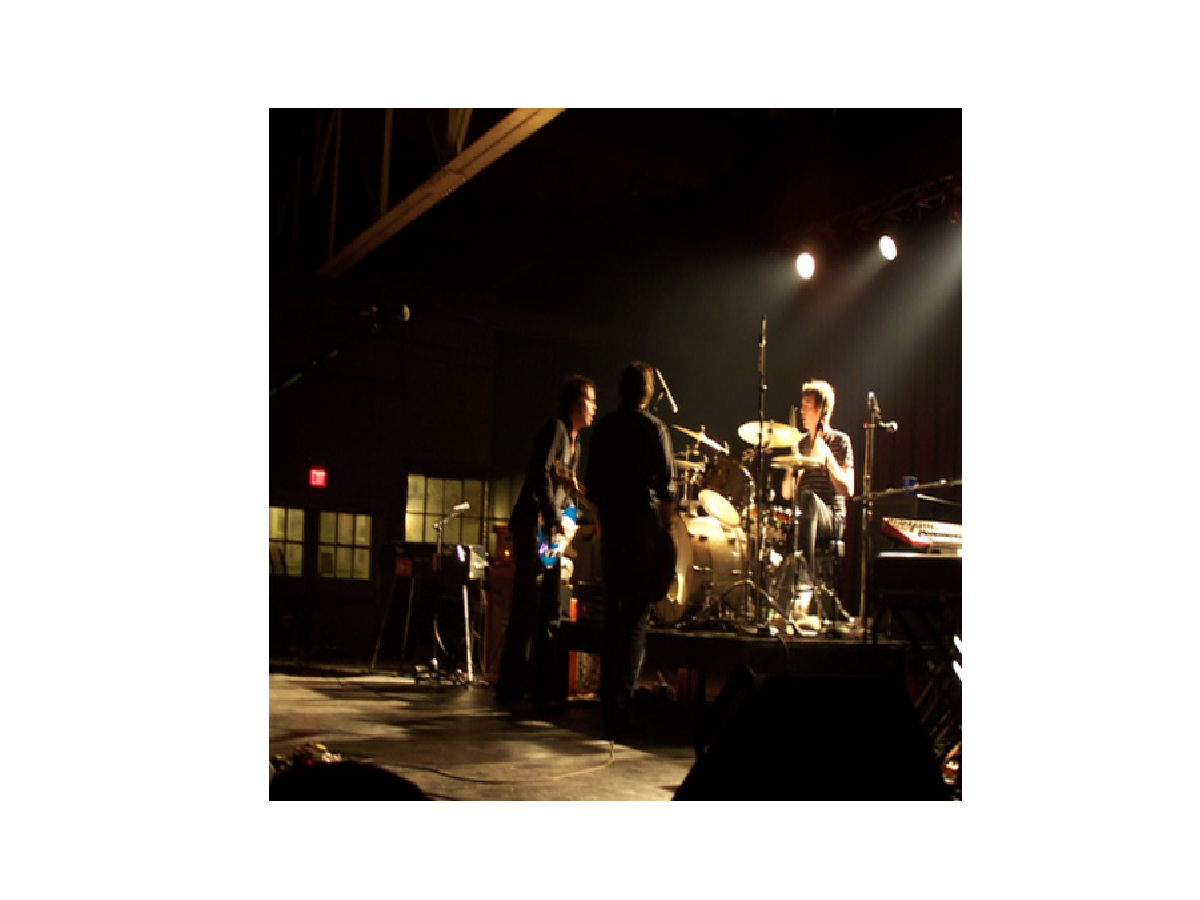

Bounding box corners tensor([[144, 161, 338, 238],
        [138, 234, 344, 293],
        [146, 369, 278, 424]])


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, a,b = train_set.__getitem__(60)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [4]:
#before running, $cd /Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)


In [5]:
feature_map = extractor(x.to(device).unsqueeze(0))


In [10]:
rpn.forward(feature_map, feature_map.shape[2:])

NameError: name 'rpn' is not defined

In [3]:
for i,a in enumerate(train_loader):
    print(i,a)
    break

0 tensor([[[[-0.1529, -0.1529, -0.1529,  ..., -0.7333, -0.8745, -0.8745],
          [-0.1922, -0.1843, -0.1765,  ..., -0.7569, -0.7020, -0.7882],
          [-0.2157, -0.2078, -0.1922,  ..., -0.7020, -0.6549, -0.7725],
          ...,
          [ 0.6000,  0.4039,  0.4353,  ...,  0.4745,  0.1137,  0.3490],
          [ 0.5922,  0.4902,  0.5059,  ...,  0.5373,  0.1765,  0.3176],
          [ 0.5843,  0.4902,  0.4431,  ...,  0.5843,  0.2941,  0.1137]],

         [[-0.1373, -0.1373, -0.1373,  ..., -0.6863, -0.7961, -0.7961],
          [-0.1765, -0.1686, -0.1608,  ..., -0.8353, -0.7333, -0.7961],
          [-0.2000, -0.1922, -0.1765,  ..., -0.8745, -0.7725, -0.8431],
          ...,
          [ 0.6157,  0.4196,  0.4510,  ...,  0.5294,  0.1686,  0.3961],
          [ 0.6078,  0.5059,  0.5216,  ...,  0.5843,  0.2314,  0.3647],
          [ 0.6078,  0.5137,  0.4667,  ...,  0.5373,  0.2471,  0.0667]],

         [[-0.1451, -0.1451, -0.1451,  ..., -0.7490, -0.8667, -0.8667],
          [-0.1843, -0.1765,

In [4]:
a.shape

torch.Size([50, 3, 520, 520])

In [9]:
x.shape

torch.Size([3, 500, 334])

In [6]:
b

tensor([60, 60, 60])

In [5]:
import os
import xml.etree.ElementTree as ET

import numpy as np

import numpy as np
from PIL import Image
import random


def read_image(path, dtype=np.float32, color=True):
    """Read an image from a file.
    This function reads an image from given file. The image is CHW format and
    the range of its value is :math:`[0, 255]`. If :obj:`color = True`, the
    order of the channels is RGB.
    Args:
        path (str): A path of image file.
        dtype: The type of array. The default value is :obj:`~numpy.float32`.
        color (bool): This option determines the number of channels.
            If :obj:`True`, the number of channels is three. In this case,
            the order of the channels is RGB. This is the default behaviour.
            If :obj:`False`, this function returns a grayscale image.
    Returns:
        ~numpy.ndarray: An image.
    """

    f = Image.open(path)
    try:
        if color:
            img = f.convert('RGB')
        else:
            img = f.convert('P')
        img = np.asarray(img, dtype=dtype)
    finally:
        if hasattr(f, 'close'):
            f.close()

    if img.ndim == 2:
        # reshape (H, W) -> (1, H, W)
        return img[np.newaxis]
    else:
        # transpose (H, W, C) -> (C, H, W)
        return img.transpose((2, 0, 1))

    
class VOCBboxDataset:
    """Bounding box dataset for PASCAL `VOC`_.
    .. _`VOC`: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/
    The index corresponds to each image.
    When queried by an index, if :obj:`return_difficult == False`,
    this dataset returns a corresponding
    :obj:`img, bbox, label`, a tuple of an image, bounding boxes and labels.
    This is the default behaviour.
    If :obj:`return_difficult == True`, this dataset returns corresponding
    :obj:`img, bbox, label, difficult`. :obj:`difficult` is a boolean array
    that indicates whether bounding boxes are labeled as difficult or not.
    The bounding boxes are packed into a two dimensional tensor of shape
    :math:`(R, 4)`, where :math:`R` is the number of bounding boxes in
    the image. The second axis represents attributes of the bounding box.
    They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`, where the
    four attributes are coordinates of the top left and the bottom right
    vertices.
    The labels are packed into a one dimensional tensor of shape :math:`(R,)`.
    :math:`R` is the number of bounding boxes in the image.
    The class name of the label :math:`l` is :math:`l` th element of
    :obj:`VOC_BBOX_LABEL_NAMES`.
    The array :obj:`difficult` is a one dimensional boolean array of shape
    :math:`(R,)`. :math:`R` is the number of bounding boxes in the image.
    If :obj:`use_difficult` is :obj:`False`, this array is
    a boolean array with all :obj:`False`.
    The type of the image, the bounding boxes and the labels are as follows.
    * :obj:`img.dtype == numpy.float32`
    * :obj:`bbox.dtype == numpy.float32`
    * :obj:`label.dtype == numpy.int32`
    * :obj:`difficult.dtype == numpy.bool`
    Args:
        data_dir (string): Path to the root of the training data. 
            i.e. "/data/image/voc/VOCdevkit/VOC2007/"
        split ({'train', 'val', 'trainval', 'test'}): Select a split of the
            dataset. :obj:`test` split is only available for
            2007 dataset.
        year ({'2007', '2012'}): Use a dataset prepared for a challenge
            held in :obj:`year`.
        use_difficult (bool): If :obj:`True`, use images that are labeled as
            difficult in the original annotation.
        return_difficult (bool): If :obj:`True`, this dataset returns
            a boolean array
            that indicates whether bounding boxes are labeled as difficult
            or not. The default value is :obj:`False`.
    """

    def __init__(self, data_dir, split='trainval',
                 use_difficult=False, return_difficult=False,
                 ):

        # if split not in ['train', 'trainval', 'val']:
        #     if not (split == 'test' and year == '2007'):
        #         warnings.warn(
        #             'please pick split from \'train\', \'trainval\', \'val\''
        #             'for 2012 dataset. For 2007 dataset, you can pick \'test\''
        #             ' in addition to the above mentioned splits.'
        #         )
        id_list_file = os.path.join(
            data_dir, 'ImageSets/Main/{0}.txt'.format(split))

        self.ids = [id_.strip() for id_ in open(id_list_file)]
        self.data_dir = data_dir
        self.use_difficult = use_difficult
        self.return_difficult = return_difficult
        self.label_names = VOC_BBOX_LABEL_NAMES

    def __len__(self):
        return len(self.ids)

    def get_example(self, i):
        """Returns the i-th example.
        Returns a color image and bounding boxes. The image is in CHW format.
        The returned image is RGB.
        Args:
            i (int): The index of the example.
        Returns:
            tuple of an image and bounding boxes
        """
        id_ = self.ids[i]
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))
        bbox = list()
        label = list()
        difficult = list()
        for obj in anno.findall('object'):
            # when in not using difficult split, and the object is
            # difficult, skipt it.
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue

            difficult.append(int(obj.find('difficult').text))
            bndbox_anno = obj.find('bndbox')
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(VOC_BBOX_LABEL_NAMES.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool).astype(np.uint8)  # PyTorch don't support np.bool

        # Load a image
        img_file = os.path.join(self.data_dir, 'JPEGImages', id_ + '.jpg')
        img = read_image(img_file, color=True)

        # if self.return_difficult:
        #     return img, bbox, label, difficult
        return img, bbox, label, difficult

    __getitem__ = get_example


VOC_BBOX_LABEL_NAMES = (
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor')

In [24]:

dataset = VOCBboxDataset(dataset_root_dir)


In [28]:
dataset.__getitem__(12)

(array([[[232., 230., 231., ...,   6.,   1.,   5.],
         [230., 228., 216., ...,   0.,   1.,  42.],
         [237., 229., 228., ...,  70.,  62.,  36.],
         ...,
         [151., 141., 143., ..., 110., 108., 116.],
         [142., 155., 154., ..., 110., 110., 120.],
         [143., 147., 149., ..., 117., 121., 122.]],
 
        [[241., 235., 242., ...,   9.,   0.,   5.],
         [234., 239., 231., ...,   3.,   7.,  37.],
         [241., 240., 241., ...,  61.,  59.,  38.],
         ...,
         [158., 146., 148., ..., 117., 115., 120.],
         [150., 161., 162., ..., 121., 120., 126.],
         [151., 153., 154., ..., 127., 131., 123.]],
 
        [[248., 241., 248., ...,  14.,   4.,   7.],
         [243., 243., 236., ...,   2.,   5.,  34.],
         [252., 244., 247., ...,  56.,  52.,  33.],
         ...,
         [151., 140., 141., ..., 123., 123., 129.],
         [137., 149., 151., ..., 117., 119., 126.],
         [138., 143., 147., ..., 118., 123., 118.]]], dtype=float32)

In [12]:
next(iter(train_loader))

tensor([[[[-0.5294, -0.5294, -0.5686,  ..., -0.8510, -0.8588, -0.7490],
          [-0.5373, -0.5608, -0.6000,  ..., -0.8353, -0.8196, -0.7176],
          [-0.5373, -0.5765, -0.5922,  ..., -0.8353, -0.8039, -0.7020],
          ...,
          [-0.1686, -0.2392, -0.2392,  ...,  0.3961,  0.4275,  0.3490],
          [-0.1765, -0.2549, -0.2078,  ...,  0.4039,  0.3882,  0.3176],
          [-0.1843, -0.2784, -0.2549,  ...,  0.3412,  0.3176,  0.2549]],

         [[-0.5059, -0.4745, -0.4902,  ..., -0.7961, -0.8039, -0.6941],
          [-0.5137, -0.5059, -0.5216,  ..., -0.7804, -0.7647, -0.6627],
          [-0.5137, -0.5216, -0.5059,  ..., -0.7725, -0.7412, -0.6392],
          ...,
          [ 0.0353, -0.0431, -0.0353,  ...,  0.3882,  0.4196,  0.3412],
          [ 0.0118, -0.0667, -0.0196,  ...,  0.3961,  0.3804,  0.3098],
          [-0.0118, -0.1059, -0.0745,  ...,  0.3333,  0.3098,  0.2471]],

         [[-0.5922, -0.6000, -0.6706,  ..., -0.8510, -0.8667, -0.7569],
          [-0.6000, -0.6314, -

In [57]:
from __future__ import  absolute_import
from __future__ import  division
import torch as t

from skimage import transform as sktsf
from torchvision import transforms as tvtsf
def resize_bbox(bbox, in_size, out_size):
    """Resize bounding boxes according to image resize.
    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.
    Args:
        bbox (~numpy.ndarray): An array whose shape is :math:`(R, 4)`.
            :math:`R` is the number of bounding boxes.
        in_size (tuple): A tuple of length 2. The height and the width
            of the image before resized.
        out_size (tuple): A tuple of length 2. The height and the width
            of the image after resized.
    Returns:
        ~numpy.ndarray:
        Bounding boxes rescaled according to the given image shapes.
    """
    bbox = bbox.copy()
    y_scale = float(out_size[0]) / in_size[0]
    x_scale = float(out_size[1]) / in_size[1]
    bbox[:, 0] = y_scale * bbox[:, 0]
    bbox[:, 2] = y_scale * bbox[:, 2]
    bbox[:, 1] = x_scale * bbox[:, 1]
    bbox[:, 3] = x_scale * bbox[:, 3]
    return bbox

def inverse_normalize(img):
    if opt.caffe_pretrain:
        img = img + (np.array([122.7717, 115.9465, 102.9801]).reshape(3, 1, 1))
        return img[::-1, :, :]
    # approximate un-normalize for visualize
    return (img * 0.225 + 0.45).clip(min=0, max=1) * 255


def pytorch_normalze(img):
    """
    https://github.com/pytorch/vision/issues/223
    return appr -1~1 RGB
    """
    normalize = tvtsf.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    img = normalize(t.from_numpy(img))
    return img.numpy()

def preprocess(img, min_size=600, max_size=1000):
    """Preprocess an image for feature extraction.
    The length of the shorter edge is scaled to :obj:`self.min_size`.
    After the scaling, if the length of the longer edge is longer than
    :param min_size:
    :obj:`self.max_size`, the image is scaled to fit the longer edge
    to :obj:`self.max_size`.
    After resizing the image, the image is subtracted by a mean image value
    :obj:`self.mean`.
    Args:
        img (~numpy.ndarray): An image. This is in CHW and RGB format.
            The range of its value is :math:`[0, 255]`.
    Returns:
        ~numpy.ndarray: A preprocessed image.
    """
    C, H, W = img.shape
    scale1 = min_size / min(H, W)
    scale2 = max_size / max(H, W)
    scale = min(scale1, scale2)
    img = img / 255.
    img = sktsf.resize(img, (C, H * scale, W * scale), mode='reflect',anti_aliasing=False)
    # both the longer and shorter should be less than
    # max_size and min_size

    return img

class Transform(object):

    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = preprocess(img, self.min_size, self.max_size)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip

        return img, bbox, label, scale
    
class Dataset:
    def __init__(self, dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"):
        self.db = VOCBboxDataset(dataset_root_dir)
        self.tsf = Transform()

    def __getitem__(self, idx):
        ori_img, bbox, label, difficult = self.db.get_example(idx)

        img, bbox, label, scale = self.tsf((ori_img, bbox, label))
        # TODO: check whose stride is negative to fix this instead copy all
        # some of the strides of a given numpy array are negative.
        return img.copy(), bbox.copy(), label.copy(), scale

    def __len__(self):
        return len(self.db)
    


In [59]:
class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.image = torch.stack(transposed_data[0], 0)
        self.bbox = torch.cat(transposed_data[1], 0)
        self.bbox_labels = torch.cat(transposed_data[2], 0)
        self.bbox_imidx = torch.cat(transposed_data[3], 0)
        self.num_objects = [len(i) for i in transposed_data[3]]

    def pin_memory(self):
        self.image = self.image.pin_memory()
        self.bbox = self.bbox.pin_memory()
        self.bbox_labels = self.bbox_labels.pin_memory()
        self.bbox_imidx = self.bbox_imdx.pin_memory()
        return self

def collate_wrapper(batch):
    return SimpleCustomBatch(batch)



In [60]:
B=50
dataloader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True, collate_fn = collate_wrapper)

In [61]:
batch = next(iter(dataloader))

In [50]:
a,b,c,d = train_set.__getitem__(30)
print(a,b,c,d)

tensor([[[-0.0431,  0.0667, -0.0353,  ...,  0.6157,  0.5922,  0.6471],
         [ 0.0039,  0.1059, -0.0039,  ...,  0.6627,  0.6392,  0.6941],
         [ 0.0431,  0.1451,  0.0275,  ...,  0.6941,  0.6706,  0.7333],
         ...,
         [-0.0039, -0.0667, -0.1843,  ..., -0.7412, -0.7176, -0.5529],
         [-0.0510, -0.0824, -0.2000,  ..., -0.6863, -0.8824, -0.7176],
         [-0.0980, -0.0902, -0.2000,  ..., -0.6392, -0.9922, -0.8588]],

        [[ 0.4824,  0.5922,  0.4902,  ...,  0.8745,  0.8510,  0.9059],
         [ 0.5294,  0.6235,  0.5137,  ...,  0.9059,  0.8824,  0.9373],
         [ 0.5686,  0.6549,  0.5294,  ...,  0.9294,  0.9059,  0.9686],
         ...,
         [-0.0353, -0.1059, -0.2235,  ..., -0.5686, -0.5294, -0.3647],
         [-0.0902, -0.1294, -0.2392,  ..., -0.5137, -0.7020, -0.5216],
         [-0.1451, -0.1373, -0.2392,  ..., -0.4667, -0.8196, -0.6549]],

        [[ 0.8196,  0.9216,  0.8588,  ...,  0.9451,  0.9216,  0.9765],
         [ 0.8667,  0.9529,  0.8824,  ...,  0

In [26]:
transposed_data = list(zip([a,b,c,d]))

In [27]:
inp = torch.stack(transposed_data[0], 0)
tgt = torch.stack(transposed_data[1], 0)
a = torch.stack(transposed_data[2], 0)
b = torch.stack(transposed_data[3], 0)

In [46]:
batch.a

tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0.]]])

In [64]:
type(batch.num_objects[0])

int